<a href="https://colab.research.google.com/github/sammitako/CS-GY-6513-Big-Data/blob/master/Keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install taxonerd

In [ ]:
!pip install --upgrade spacy

In [ ]:
!pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_biobert-1.0.2.tar.gz

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-Levenshtein

In [ ]:
# import libraries
import spacy
import csv
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
from rapidfuzz import process
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import re
from collections import Counter
from taxonerd import TaxoNERD


# Selecting the column for species extraction.
>Upon analyzing the data, we discovered that the 'name', 'title', and 'product' columns contain identical data in the field. Therefore, we chose the 'product' column as it has the longest average text length.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BigData/TeamNotebook/data/preprocessed_data_file_geography_price_removed_outliers.csv')
df.info()

In [ ]:
avg_length_product = df['product_fingerprint'].apply(lambda x: len(str(x))).mean()
avg_length_name = df['name_fingerprint'].apply(lambda x: len(str(x))).mean()
avg_length_title = df['title_fingerprint'].apply(lambda x: len(str(x))).mean()

avg_lengths = {
    'product_fingerprint': avg_length_product,
    'name_fingerprint': avg_length_name,
    'title_fingerprint': avg_length_title
}

# Find the column with the longest average text length
column_with_longest_avg = max(avg_lengths, key=avg_lengths.get)
print(f"The column with the longest average text length is: {column_with_longest_avg} with an average length of {avg_lengths[column_with_longest_avg]}")

*Drop* the columns 'name', 'title', 'product', and 'description' from DataFrame and then rename the `*_fingerprint` columns to just the base column names (like 'name')

In [ ]:
df = df.drop(columns=['name', 'title', 'product', 'description'])

df = df.rename(columns={
    'name_fingerprint': 'name',
    'title_fingerprint': 'title',
    'product_fingerprint': 'product',
    'description_fingerprint': 'description'
})

# Reordering the columns
columns_first = ['name', 'title', 'product', 'description']
remaining_columns = [col for col in df.columns if col not in columns_first]
new_column_order = columns_first + remaining_columns
df = df[new_column_order]
df.head()

17433

# Data pre-processing: Removing duplicates

In [ ]:
# product_fingerprint column.
df['product']

In [ ]:
# The unique values that have duplicates
duplicate_values = df.loc[df['product'].duplicated(keep='first'), 'product'].unique()

print(len(duplicate_values))

name       17269
product    17414
title      17414
dtype: int64

In [ ]:
print(duplicate_values[0])

In [ ]:
first_duplicate_value = duplicate_values[0]
rows_with_first_duplicate = df[df['product'] == first_duplicate_value]

rows_with_first_duplicate

We observed that the same advertisements are posted on different URLs. Upon examination, we noted that the 'name', 'title', and 'product' are the same; however, the descriptions vary:

- Remove duplicate rows where 'name', 'title', and 'product' are the same.
- Remove duplicate rows where the description is the same.

In [ ]:
# Step 1
df = df.drop_duplicates(subset=['name', 'title', 'product'])

# Step 2
df = df.drop_duplicates(subset=['description'])

In [ ]:
# name, title, product: 51610 -> 17433 (-34177)
# description: 51306 -> 17432 (-33874)
df.info()

In [ ]:
# product_fingerprint column.
df.head(10)

In [ ]:
final_file_path = '/content/drive/MyDrive/BigData/TeamNotebook/data/final_cleaned_data.csv'
df.to_csv(final_file_path, index=False)

# Data pre-proceesing: Removing rows not related to wildlife trafficking.

### We remove rows where the product description indicates that it might not be related to wildlife trading.
>From the dataset, we remove rows that have terms such as 'faux' and 'replica' in the product column which implies that the product is not a real animal or an animal body part. More examples: 'peluche' translates to stuffed toy, so we will remove those entries too.

In [ ]:
non_animal_product_list = ['faux','replica','toolbox','hardback','toy','figure','tool','book','peluche','juguete']

In [ ]:
df = df[~df['product'].str.contains('|'.join(non_animal_product_list), na=False)]

In [ ]:
df.shape[0]

16234

>Approximately 1000 entries are removed from the dataset.

### Retain rows that contains certain common keywords.
>In contrary to the previous approach, we can also assume that an ad listing is related to wildlife trafficking if the product column contain certain keywords. We load the pre-defined most common keywords from the 'common_kws.txt' file and retain those ad listings which have any matching keywords from the file.

In [ ]:
# Load the most common keywords and form a set of common words.
common_kws =  set(open('common_kws.txt').read().lower().split())

In [ ]:
print(common_kws)

{'alligator', 'reptile', 'bird', 'ivy', 'tooth', 'snake', 'claw', 'feet', 'falcon', 'colored', 'feather', 'ivorine', 'carcass', 'cheetah', 'shark', 'sparrowhawk', 'okimono', 'elephant', 'primate', 'bovine', 'schreger', 'graining', 'teeth', 'skeleton', 'ox', 'turtle', 'crocodile', 'leopard', 'goshawk', 'lizard', 'bone', 'trophy', 'antique', 'scale', 'tiger', 'meat', 'python', 'tortoise', 'lynx', 'lines', 'skull', 'taxidermy', 'bile', 'birds', 'otter', 'ocelot', 'of', 'parrot', 'pelt', 'patina', 'chinese', 'carved', 'cites', 'hide', 'leather', 'fake', 'cobra', 'natural', 'owl', 'varanus', 'caviar', 'carving', 'macaw', 'live', 'lemur', 'rhinoceros', 'material', 'foot', 'macaque', 'cow', 'pangolin', 'paw', 'bear', 'excotic', 'monkey', 'fur', 'clam', 'scrimshaw', 'oil', 'tusk', 'horn', 'chimpanzee', 'pet', 'shatoosh', 'eagle', 'boa', 'skin', 'wildlife', 'shell', 'ivory', 'deep', 'hair', 'faux', 'gorilla', 'cross-hatch', 'egg', 'lion', 'grain', 'netsuke', 'coloured', 'prey'}


In [ ]:
# Retain the rows that contain any matching common keywords.
df = df[df['product'].str.contains('|'.join(common_kws), na=False)]

In [ ]:
df.head(5)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
0,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and at best bones color deals ebay ...,ebay.com.au,Australia,an animal body part,22.25,AUD,NaN,https://images.awesomebooks.com/images/books/r...,https://www.ebay.com.au/itm/384104329587?amdat...,NaN,au,Australia,34
1,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,and at best contortus deals delivery ebay find...,ebay.co.uk,United Kingdom,an animal body part,12.63,GBP,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.co.uk/itm/222613331802,NaN,uk,United Kingdom,10
2,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,and at azaz best contortus deals ebay find for...,ebay.com,NaN,an animal body part,111.39,CNY,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.com/itm/222613331802?_ul=CN,NaN,com,NaN,790
5,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada and at best brinquedo d de deals ebay...,ebay.com,NaN,an animal body part,74.43,EUR,NaN,https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxO...,https://www.ebay.com/itm/155807567987?_ul=PT,NaN,com,NaN,68
7,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,and at best black crafts deals decorations del...,ebay.co.uk,United Kingdom,an animal body part,9.58,GBP,NaN,https://i.ebayimg.com/images/g/Q1IAAOSws29lGwl...,https://www.ebay.co.uk/itm/314864391496?amdata...,NaN,uk,United Kingdom,8


In [ ]:
df.shape[0]

8667

When considering rows that contains any of the common keywords, the data is further reduced to about 8600 entries.

## Data pre-processing - 'product' column for species extraction.
To extract the species from each row, we tokenize the product column in an attempt to find relevant keywords. But the column contains a lot of text, most of which are irrelevant to the species name. By removing these words, we remove the low-level information from the product description in order to give more focus to the species name.

### Removing stopwords, numerals and other irreleavant words.
Stopwords are the most common words in any language (ex. articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”.
>We will also remove numerals, verbs, and other words which are not relavant to species name.
>The removal of such words will not have any negative consequences for our task. It reduces the number of tokens and leads to a more accurate species extraction.

In [ ]:
# product column.
df['product'].head(10)

0     adventures and bones color ebay hailstones hal...
1     contortus ebay hill miocene physogaleus shark ...
2       azaz contortus ebay hill physogaleus sharktooth
5     almofada brinquedo d de ebay estereo gato peca...
7     black crafts decorations dining ebay feathers ...
8     black centerpiece ebay feathers large ostrich ...
9     assorted colors craft crown ebay feathers larg...
10    assorted black colors craft decoration ebay fe...
11    black colored craft decoration ebay feathers o...
12    black decoration decorations ebay feathers gol...
Name: product, dtype: object

In [ ]:
import spacy

In [ ]:
# Loading the english language small model of spacy
en = spacy.load("en_core_web_sm")

Spacy is used to tokenize text and after tokenization, it can parse and tag a given Doc.
The trained pipeline enables spaCy to make predictions of which tag or label most likely applies in this context.

In [ ]:
df['product'].head(10).iloc[1]

'contortus ebay hill miocene physogaleus shark sharktooth tiger tooth'

In [ ]:
# Example of using spaCy to tokenize and tag a Doc.
original_text = "contortus ebay hill miocene physogaleus shark sharktooth tiger tooth"
doc = en(original_text.lower())
for token in doc:
    print(token.text, token.pos_)

contortus PROPN
ebay PROPN
hill PROPN
miocene PROPN
physogaleus PROPN
shark PROPN
sharktooth NOUN
tiger NOUN
tooth NOUN


In [ ]:
# Only nouns, proper nouns and adjectives will be retained from the text.
def retain_words_with_tags(text):
    result = []
    pos_tags = ['PROPN', 'NOUN', 'ADJ']
    doc = en(text.lower())

    words = [token.text for token in doc if token.pos_ in pos_tags]

    result = ' '.join(words)

    return result

In [ ]:
# Another example.
original_text = "adornment ears ebay fox hair headband headdress plush props sets suit tail wolf"
filtered_text = retain_words_with_tags(original_text)
print(filtered_text)

adornment ears ebay fox hair headband headdress plush props suit wolf


In [ ]:
# Example of using spaCy to retain PROPN, NOUN and ADJ tags.
original_text = "This is the 3rd example sentence with nouns like cat and dog."
filtered_text = retain_words_with_tags(original_text)
print(filtered_text)

3rd example sentence nouns cat dog


We will populate a new column 'product_cleaned' that will be used to retain keywords for species extraction.

In [ ]:
df['product_cleaned'] = df['product'].apply(retain_words_with_tags)

In [ ]:
# cleaned product column after retaining PROPN, NOUN and ADJ tags.
df['product_cleaned'].head(10)

0     adventures bones color ebay hailstones mary on...
1     contortus ebay hill miocene physogaleus shark ...
2       azaz contortus ebay hill physogaleus sharktooth
5     almofada brinquedo ebay estereo gato peca pelu...
7     black crafts decorations ebay feathers federn ...
8     black centerpiece ebay feathers large ostrich ...
9     colors craft crown ebay feathers large ostrich...
10      black colors craft decoration ebay feathers pcs
11    black colored craft decoration ebay feathers p...
12    black decoration decorations ebay feathers gol...
Name: product_cleaned, dtype: object

# Species extraction from the product column using String similarity and Matching.

## Fuzzy String Matching
We will use rapidfuzzy, a python library for comparing text based on the similarity of strings. The library uses Levenshtein distance to calculate the difference between two strings. It is an alternative to the fuzzywuzzy library and provides fast and efficient string matching and fuzzy string matching functions.

Partial Ratio: It finds the ratio similarity measure between the shorter string and every substring of length m of the longer string, and returns the maximum of those similarity measures. Basically, it searches for the optimal alignment of the shorter string in the longer string and returns the fuzz.ratio for this alignment.

The extractOne function returns a tuple containing the best matching string and its similarity score. The similarity score is computed using the token set ratio as specified in the parameters.


In [ ]:
# Example of using rapidfuzz string matching.
example_text = df['product'].head(10).iloc[5]
print(example_text)

black centerpiece ebay feathers large ostrich pcs wedding white


In [ ]:
fuzz.partial_ratio(example_text, "ostrich")

100.0

In [ ]:
process.extractOne(example_text, animal_list, scorer=fuzz.partial_ratio)

('ostrich', 100.0, 5143)

>The 'final_animal_list.csv' file contains 8130 entries of animal species names. It contains normalized Specific species name and also their General names and we will use the Specific names to form a list of animals.
We will check if our dataset contains any of the animals listed here.
Using similarity search, we will compare the long text in the 'product_cleaned' column and find if any part of that text matches with anything in the animal list.

In [ ]:
animal_list_df = pd.read_csv('/content/drive/MyDrive/BigData/TeamNotebook/data/final_animal_list.csv')
animal_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8130 entries, 0 to 8129
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Distribution Country       8047 non-null   object
 1   Specific Names             8130 non-null   object
 2   Specific Names Normalized  8130 non-null   object
 3   General Names Normalized   8130 non-null   object
dtypes: object(4)
memory usage: 254.2+ KB


In [ ]:
animal_list_df.head()

,Distribution Country,Specific Names,Specific Names Normalized,General Names Normalized
0,"Angola, Botswana, Central African Republic, Dj...",Aardwolf,aardwolf,aardwolf
1,Bahamas,Abaco Island Boa,abaco island boa,boa
2,"Australia, Christmas Island, Indonesia, Maurit...",Abbott's Booby,abbotts booby,booby
3,"Madagascar, Seychelles",Abbott's Day Gecko,abbotts day gecko,gecko
4,Italy,Abruzzo Chamois,abruzzo chamois,chamois


In [ ]:
animal_list = animal_list_df['Specific Names Normalized'].tolist()

In [ ]:
animal_list

In [ ]:
# Check if any part of the text matches with items in the search_list
def find_best_match(text, search_list):
    best_match, score, index = process.extractOne(text, search_list, scorer=fuzz.token_set_ratio)
    threshold = 90
    if score >= threshold:
        return best_match
    else:
        return None

The 'find_best_match' function returns the best match if any part of the text has a token_set_ratio greater than 95 with any item in the search list. The 'product_cleaned' might have more than one potential match, but we will consider the best match out of all the potential matches. The threshold is set to 95 as we are trying to find the exact spacies name.

In [ ]:
# Apply the similarity search function to the 'product_cleaned' column
df['species'] = df['product_cleaned'].apply(lambda x: find_best_match(x, animal_list))

In [ ]:
df[['product_cleaned','species']].head()

,product_cleaned,species
0,adventures bones color ebay hailstones mary on...,None
1,contortus ebay hill miocene physogaleus shark ...,tiger
2,azaz contortus ebay hill physogaleus sharktooth,None
5,almofada brinquedo ebay estereo gato peca pelu...,None
7,black crafts decorations ebay feathers federn ...,ostrich


In [ ]:
df['species'].notna().sum()

5273

We were able to find the species name for 5273 rows.

## Finding the most commonly traded animal species

In [ ]:
wildlife_count = df['species'].value_counts().reset_index()
wildlife_count.columns = ['species', 'count']
wildlife_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   species  123 non-null    object
 1   count    123 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [ ]:
wildlife_count.head(10)

,species,count
0,ostrich,1343
1,great white shark,1272
2,wolf,763
3,tiger,526
4,nile crocodile,445
5,blue shark,122
6,crocodiles,72
7,silky shark,59
8,white shark,57
9,bull shark,55


# Visulization of wildlife trade

In [ ]:
fig = px.pie(wildlife_count.head(10), values='count', names='species',
             title='Top 10 traded animals')
fig.show()

In [ ]:
fig = px.bar(wildlife_count.head(20), y='count', x='species', color='species',
             title="Top 20 traded animals", text=wildlife_count.head(20)['count'].astype(str))
fig.show()

In [ ]:
wildlife_trade_df = df[df['species'].notna()]
wildlife_trade_country_count = wildlife_trade_df['country'].value_counts().reset_index()
wildlife_trade_country_count.columns = ['country', 'count']

In [ ]:
wildlife_trade_country_count.head(10)

,country,count
0,United States,1361
1,Canada,632
2,United Kingdom,584
3,Australia,495
4,France,217
5,Singapore,157
6,Germany,146
7,Ireland,116
8,Italy,108
9,New Zealand,85


In [ ]:
fig = px.choropleth(wildlife_trade_country_count, locations="country", locationmode='country names',
                    color="count", hover_name="country", projection='natural earth',
                    title='Geographical distribution of wildlife trade ad listings')

fig.show()

# Price range of wildlife traded online

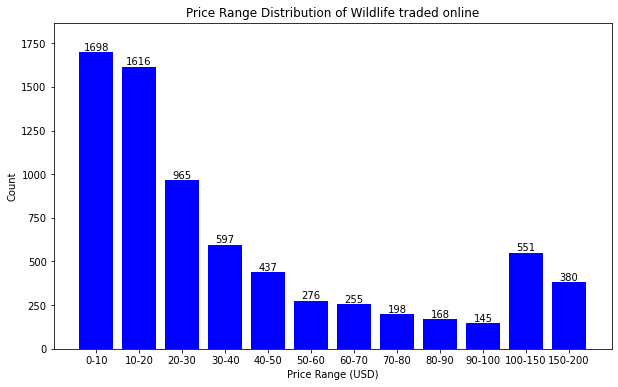

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-150', '150-200']
df['price_range'] = pd.cut(df['normalized_price_usd'], bins=bins, labels=labels, right=False)

price_range_counts = df['price_range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(price_range_counts.index.astype(str), price_range_counts.values, color='blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Price Range (USD)')
plt.ylabel('Count')
plt.title('Price Range Distribution of Wildlife traded online')

plt.ylim(0, price_range_counts.max() * 1.1)

plt.show()

# Finding animals that are illegal to trade and are in danger of extinction.
The master data 'animals_paper_top10.txt' contains the list of top 10 animals that are illegal to trade and are in danger of extinction. We will find if our dataset contains any of the animals listed here.

### Master data with lists of animals that are illegal to trade and are in danger of extinction
The data contains the common names and the scientific names of the animals.

In [ ]:
illegal_animal_list = open('/content/drive/MyDrive/BigData/TeamNotebook/data/animals_paper_top10.txt').read().lower().split('\n')

In [ ]:
illegal_animal_list

['struthio camelus',
 'ostrich',
 'canis lupus',
 'wolf',
 'carcharhinus falciformis',
 'silky shark',
 'carcharhinus longimanus',
 'great white shark',
 'carcharias taurus',
 'sand tiger shark',
 'caiman latirostris',
 'caiman latirostris',
 'hippoglossus hippoglossus',
 'halibut',
 'calathus lundbladi',
 'ground beetle',
 'crocodylus niloticus',
 'nile crocodile',
 'sebastes fasciatus',
 'redfish']

In [ ]:
# Apply the similarity search function to the 'product_cleaned' column
df['endangered_species'] = df['product_cleaned'].apply(lambda x: find_best_match(x, illegal_animal_list))

In [ ]:
df[['product_cleaned','endangered_species']].head()

,product_cleaned,endangered_species
0,adventures bones color ebay hailstones mary on...,None
1,contortus ebay hill miocene physogaleus shark ...,None
2,azaz contortus ebay hill physogaleus sharktooth,None
5,almofada brinquedo ebay estereo gato peca pelu...,None
7,black crafts decorations ebay feathers federn ...,ostrich


In [ ]:
illegal_trade_df = df[df['endangered_species'].notna()]

In [ ]:
illegal_trade_df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,product_cleaned,endangered_species
7,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,and at best black crafts deals decorations del...,ebay.co.uk,United Kingdom,an animal body part,9.58,GBP,NaN,https://i.ebayimg.com/images/g/Q1IAAOSws29lGwl...,https://www.ebay.co.uk/itm/314864391496?amdata...,NaN,uk,United Kingdom,8,black crafts decorations ebay feathers federn ...,ostrich
8,black centerpiece ebay feathers large ostrich ...,black centerpiece ebay feathers large ostrich ...,black centerpiece ebay feathers large ostrich ...,and at best black centerpiece deals delivery e...,ebay.co.uk,United Kingdom,an animal body part,8.31,GBP,NaN,https://i.ebayimg.com/images/g/UukAAOSwlfJlGwl...,https://www.ebay.co.uk/itm/314864424353?amdata...,NaN,uk,United Kingdom,7,black centerpiece ebay feathers large ostrich ...,ostrich
9,assorted colors craft crown ebay feathers larg...,assorted colors craft crown ebay feathers larg...,assorted colors craft crown ebay feathers larg...,and assorted at best colors craft crown deals ...,ebay.ca,Canada,an animal body part,12.79,CAD,NaN,https://i.ebayimg.com/images/g/4IQAAOSwmHtlGwk...,https://www.ebay.ca/itm/314864388058,NaN,ca,Canada,17,colors craft crown ebay feathers large ostrich...,ostrich
12,black decoration decorations ebay feathers gol...,black decoration decorations ebay feathers gol...,black decoration decorations ebay feathers gol...,and at best black deals decoration decorations...,ebay.co.uk,United Kingdom,an animal body part,9.08,GBP,NaN,https://i.ebayimg.com/images/g/0IkAAOSwuz9lGwl...,https://www.ebay.co.uk/itm/314864390357?amdata...,NaN,uk,United Kingdom,7,black decoration decorations ebay feathers gol...,ostrich
14,accessories colored decor ebay feathers large ...,accessories colored decor ebay feathers large ...,accessories colored decor ebay feathers large ...,accessories colored crafts decor ebay embellis...,ebay.com.sg,Singapore,an animal body part,15.92,SGD,NaN,https://i.ebayimg.com/images/g/ygkAAOSwN~hlGh9...,https://www.ebay.com.sg/itm/386162806730?amdat...,NaN,sg,Singapore,21,accessories decor ebay feathers large ostrich ...,ostrich


In [ ]:
illegal_trade_df.shape[0]

4592

# Visulization of potentially illegal wildlife trade

In [ ]:
illegal_trade_count = illegal_trade_df['endangered_species'].value_counts().reset_index()
illegal_trade_count.columns = ['endangered_species', 'count']

In [ ]:
illegal_trade_count

,endangered_species,count
0,great white shark,1343
1,ostrich,1320
2,wolf,821
3,nile crocodile,479
4,sand tiger shark,161
5,halibut,109
6,struthio camelus,73
7,silky shark,67
8,crocodylus niloticus,59
9,redfish,46


The illegal_animal_list have both the common names and scientific names of the top 10 illegally traded animals. We will now combine the rows with the same species name to get a total count.

In [ ]:
species_names_mapping = {
    'struthio camelus': 'ostrich',
    'canis lupus': 'wolf',
    'carcharhinus falciformis': 'silky shark',
    'carcharhinus longimanus': 'great white shark',
    'carcharias taurus': 'sand tiger shark',
    'hippoglossus hippoglossus': 'halibut',
    'calathus lundbladi': 'ground beetle',
    'struthio camelus': 'ostrich',
    'crocodylus niloticus': 'nile crocodile',
    'sebastes fasciatus': 'redfish'
}

In [ ]:
for index, row in illegal_trade_count.iterrows():
    if row['endangered_species'] in species_names_mapping:
        illegal_trade_count.at[index, 'endangered_species'] = species_names_mapping[row['endangered_species']]

In [ ]:
illegal_trade_count

,endangered_species,count
0,great white shark,1343
1,ostrich,1320
2,wolf,821
3,nile crocodile,479
4,sand tiger shark,161
5,halibut,109
6,ostrich,73
7,silky shark,67
8,nile crocodile,59
9,redfish,46


In [ ]:
top_10_illegally_traded_wildlife = illegal_trade_count.groupby('endangered_species')['count'].sum().reset_index()

In [ ]:
top_10_illegally_traded_wildlife

,endangered_species,count
0,caiman latirostris,32
1,great white shark,1346
2,ground beetle,27
3,halibut,113
4,nile crocodile,538
5,ostrich,1393
6,redfish,47
7,sand tiger shark,168
8,silky shark,68
9,wolf,860


In [ ]:
import plotly.express as px

In [ ]:
fig = px.pie(top_10_illegally_traded_wildlife, values='count', names='endangered_species',
             title='Top 10 Illegally traded animals')
fig.show()

In [ ]:
fig = px.bar(top_10_illegally_traded_wildlife, y='count', x='endangered_species', color='endangered_species',
             title="Top 10 Illegally traded animals", text=top_10_illegally_traded_wildlife['count'].astype(str))
fig.show()

In [ ]:
illegal_trade_country_count = illegal_trade_df['country'].value_counts().reset_index()
illegal_trade_country_count.columns = ['country', 'count']

In [ ]:
illegal_trade_country_count.head(10)

,country,count
0,United States,1064
1,Canada,562
2,United Kingdom,560
3,Australia,455
4,France,180
5,Singapore,154
6,Germany,111
7,Ireland,104
8,Italy,93
9,New Zealand,80


In [ ]:
fig = px.choropleth(illegal_trade_country_count, locations="country", locationmode='country names',
                    color="count", hover_name="country", projection='natural earth',
                    title='Geographical distribution of ad listings that is a potential Illegal wildlife trade')

fig.show()

### Remove irrelevant common words.
Find the most common words that are irrelevant for species extraction and remove them from the 'product_cleaned' column.

In [ ]:
from collections import Counter

In [ ]:
# The most common 800 words.
common_words = [i[0] for i in Counter(" ".join(df['product_cleaned']).split()).most_common()[:800]]

These are the most common words in the 'product_cleaned' column. To make species extraction faster and accurate, we will remove some of these words which are not part of the 'common_kws.txt' file

In [ ]:
# From the list of illegal animals, form a set of keywords.
split_words = [word for phrase in illegal_animal_list for word in phrase.split()]
illegal_animal_kws = set(split_words)

In [ ]:
print(illegal_animal_kws)

In [ ]:
irrelevant_common_words = [word for word in common_words if word not in common_kws and word not in illegal_animal_set]

In [ ]:
print(irrelevant_common_words)

['ebay', 'picclick', 'mens', 'black', 'boots', 'size', 'fossil', 'cowboy', 'new', 'brown', 'genuine', 'vintage', 'jaws', 'western', 'megalodon', 'blue', 'animal', 'head', 'real', 'tshirt', 'silver', 'shirt', 'necklace', 'pendant', 'mm', 'sale', 'large', 'trade', 'fish', 'pcs', 'mnh', 'full', 'toe', 'men', 'cm', 'exotic', 'd', 'red', 'inch', 'jaw', 'ebid', 'womens', 'nil', 'wild', 'feathers', 'lot', 't', 'quill', 'bag', 'art', 'rare', 'florida', 'decor', 'xl', 'plush', 'lucchese', 'soft', 'sharks', 'ocean', 'high', 'w', 'coin', 'usa', 'free', 'sea', 'handmade', 'top', 'statue', 'box', 'wallet', 'pack', 'leg', 'mount', 'gift', 'mako', 'hand', 'monster', 'green', 'bull', 'square', 'united', 'card', 'lama', 'quality', 'baby', 'wolves', 'du', 'kingdom', 'shoes', 'figurine', 'l', 'nike', 'ee', 'tony', 'decoration', 'small', 'air', 'collection', 'c', 'crocodiles', 'party', 'gold', 'vinyl', 'de', 'strap', 'christmas', 'women', 'tee', 'dress', 'american', 'belt', 'sz', 'boot', 'diver', 'fishing

In [ ]:
len(irrelevant_common_words)

735

In [ ]:
def remove_irrelevant_words(text):
    # Tokenize the text
    words = text.split()

    # Remove irrelevant words
    words = [word for word in words if word.lower() not in irrelevant_common_words]

    cleaned_text = ' '.join(words)

    return cleaned_text

In [ ]:
df['product_cleaned'] = df['product_cleaned'].apply(remove_irrelevant_words)

In [ ]:
df['product_cleaned'].tail(10)

17399                                                tiger
17401                                                teeth
17407                             proximus scitulus tachys
17418                     merops niloticus nubicus varanus
17419                                       mastige proofs
17427                              great iuuou shark white
17428    crocodile dollars iaia islands nile solomon sp...
17429                                    ieatanzania polar
17431                              bone iiblue shark tooth
17432                                          shark white
Name: product_cleaned, dtype: object

After removing irrelevant words from the 'product_cleaned' column, some rows are left empty for this column. So, we will remove them from our dataset.

In [ ]:
df = df[~(df['product_cleaned'] == '')]

In [ ]:
df.shape[0]

8628

We removed around 50 rows.

# Species extraction using TaxoNERD
TaxoNERD is a domain-specific tool for recognizing taxon mentions in the biodiversity literature.
We will use the 'en_core_eco_biobert' model to extract species name from the text in the pre-processed 'product' column.

In [ ]:
pip install taxonerd

In [ ]:
pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_biobert-1.0.2.tar.gz

In [ ]:
from taxonerd import TaxoNERD

In [ ]:
taxonerd = TaxoNERD(prefer_gpu=False)

In [ ]:
# Load taxonerd model
nlp = taxonerd.load(model="en_core_eco_biobert")

In [ ]:
# Example of using taxonerd to extract species from text.
taxonerd.find_in_text("shark white tshirt")

,offsets,text,sent
T0,LIVB 0 18,shark white tshirt,0


In [ ]:
def get_species(name):
    try:
        doc = nlp(name)
        return doc.ents[0]
    except:
        return None

In [ ]:
df['species'] = df['product_cleaned'].apply(get_species)

In [ ]:
df.head(5)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,product_cleaned,species
0,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and at best bones color deals ebay ...,ebay.com.au,Australia,an animal body part,22.25,AUD,NaN,https://images.awesomebooks.com/images/books/r...,https://www.ebay.com.au/itm/384104329587?amdat...,NaN,au,Australia,34,adventures hailstones mary oneill,None
1,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,and at best contortus deals delivery ebay find...,ebay.co.uk,United Kingdom,an animal body part,12.63,GBP,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.co.uk/itm/222613331802,NaN,uk,United Kingdom,10,contortus hill physogaleus shark sharktooth ti...,(contortus)
2,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,and at azaz best contortus deals ebay find for...,ebay.com,NaN,an animal body part,111.39,CNY,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.com/itm/222613331802?_ul=CN,NaN,com,NaN,790,azaz contortus hill physogaleus sharktooth,"(azaz, contortus)"
5,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada and at best brinquedo d de deals ebay...,ebay.com,NaN,an animal body part,74.43,EUR,NaN,https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxO...,https://www.ebay.com/itm/155807567987?_ul=PT,NaN,com,NaN,68,almofada estereo gato peca pelucia simulado tr...,None
7,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,and at best black crafts deals decorations del...,ebay.co.uk,United Kingdom,an animal body part,9.58,GBP,NaN,https://i.ebayimg.com/images/g/Q1IAAOSws29lGwl...,https://www.ebay.co.uk/itm/314864391496?amdata...,NaN,uk,United Kingdom,8,decorations federn kanstliche ostrich,None


In [ ]:
df['species'].notna().sum()

3666

In [ ]:
df2 = df[df['species'].notna()]

In [ ]:
df2.head(5)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,product_cleaned,species,illegal_trade
17399,ebay gi joe tiger,ebay gi joe tiger,ebay gi joe tiger,and at best deals ebay find for free get gi gr...,ebay.com,NaN,an animal body part,146.01,CNY,NaN,https://i.ebayimg.com/images/g/4tAAAOSwz~5lCHl...,https://www.ebay.com/itm/285479518791?_ul=CN,NaN,com,NaN,1036,tiger,(tiger),[sand tiger shark]
17418,ebay merops niloticus nubicus ss varanus,ebay merops niloticus nubicus ss varanus,ebay merops niloticus nubicus ss varanus,and at best deals ebay find for free get great...,ebay.com,NaN,an animal body part,135.27,CNY,NaN,https://i.ebayimg.com/images/g/3LUAAOSwg81k0hQ...,https://www.ebay.com/itm/126037313863?_ul=CN,NaN,com,NaN,959,merops niloticus nubicus varanus,"(merops, niloticus, nubicus, varanus)",None
17427,adventure ebay great iuuou planet plush shark ...,adventure ebay great iuuou planet plush shark ...,adventure ebay great iuuou planet plush shark ...,adventure animals ebay great hobbies iuuou oth...,ebay.com.my,Malaysia,an animal body part,14.10,MYR,NaN,https://i.ebayimg.com/images/g/c~MAAOSwnwNlCIc...,https://www.ebay.com.my/itm/374938087872?amdat...,NaN,my,Malaysia,66,great iuuou shark white,"(great, iuuou, shark)",None
17429,fish ieatanzania life marine mnh neuf polar sh...,fish ieatanzania life marine mnh neuf picclick...,fish ieatanzania life marine mnh neuf picclick...,TMee a aa accepted altrove america at attentio...,picclick.com,United States,an animal body part,4.00,USD,NaN,https://www.picclickimg.com/qOIAAOSwMa5lEyWz/T...,http://picclick.com/%F0%9F%91%89TANZANIA-2000-...,"Long Beach, New York, US",com,NaN,4,ieatanzania polar,(ieatanzania),None
17432,ebay funnyauiiii iiiigreat large shark size ts...,ebay funnyauiiii iiiigreat large shark size ts...,ebay funnyauiiii iiiigreat large shark size ts...,and at best deals ebay find for free funnyauii...,ebay.ca,Canada,an animal body part,13.67,CAD,NaN,https://i.ebayimg.com/images/g/8tgAAOSwD7ljYZm...,https://www.ebay.ca/itm/115927314157?amdata=en...,NaN,ca,Canada,19,shark white,"(shark, white)",None


# References
https://spacy.io/usage/linguistic-features#morphology
https://www.analyticsvidhya.com/blog/2022/03/keyword-extraction-methods-from-documents-in-nlp/#h-spacy
https://pypi.org/project/taxonerd/
https://pypi.org/project/fuzzywuzzy/
https://medium.com/mlearning-ai/all-about-rapidfuzz-string-similarity-and-matching-cd26fdc963d8#:~:text=3.,the%20ratio%20will%20be%20100.
https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
https://www.analyticsvidhya.com/blog/2021/06/fuzzywuzzy-python-library-interesting-tool-for-nlp-and-text-analytics/